In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-

# @Author	:	yuansc
# @Contact	:	yuansicheng@ihep.ac.cn
# @Date		:	2022-11-16

import os, sys, argparse, logging

import pandas as pd
import numpy as np
import uproot
from glob import glob

import math

from distfit import distfit

import matplotlib
import matplotlib.pyplot as plt

this_path = os.path.abspath('.')

In [6]:
root_files = glob(os.path.join(this_path, '../../data/gen/single_p+_fixed_enery_and_direction/lh1.0/*.root'))
root_files

['../../data/gen/single_p+_fixed_enery_and_direction/lh1.0\\0.root']

In [7]:
def readOneFile(root_file):
    print(root_file)
    tree = uproot.open(root_file)['RecInfo']

    df = pd.DataFrame()

    # 最大动量为p的index
    p_index = [np.argmax(p) if len(p) else None for p in tree['mdc_p'].array()]

    for key in ['mdc_p', 'mdc_px', 'mdc_py', 'mdc_pz']:
        tmp = tree[key].array()
        df[key] = [tmp[i][p_index[i]] for i in range(len(p_index)) if not p_index[i] is None]

    # 去掉异常值
    mdc_p_mean = np.array(df.mdc_p).mean()
    mdc_p_std = np.array(df.mdc_p).std()
    df = df.loc[
        (df.mdc_p > mdc_p_mean-mdc_p_std) & 
        (df.mdc_p < mdc_p_mean+mdc_p_std)
    ]

    return df

In [8]:
df_list = []
for root_file in root_files:
    df_list.append(readOneFile(root_file))
df = pd.concat(df_list)

df

../../data/gen/single_p+_fixed_enery_and_direction/lh1.0\0.root


,mdc_p,mdc_px,mdc_py,mdc_pz
0,1.002014,0.759573,0.414861,0.504948
1,1.004034,0.764311,0.419622,0.497825
2,1.002024,0.762336,0.416883,0.499105
3,0.997335,0.755788,0.413310,0.502629
4,1.000192,0.760925,0.415335,0.498872
...,...,...,...,...
994,0.999798,0.759151,0.415870,0.500337
995,0.993222,0.755098,0.409369,0.498734
996,0.991524,0.756367,0.408361,0.494237
997,1.007727,0.766401,0.417365,0.503934


In [9]:
def pthetaphi2Pxpypz(p, theta, phi):
    px = p * math.sin(theta) * math.cos(phi)
    py = p * math.sin(theta) * math.sin(phi)
    pz = p * math.cos(theta)
    return px, py, pz

In [10]:
mc_p_vec = np.array(pthetaphi2Pxpypz(1, math.acos(0.5), 0.5))
mc_p_vec

array([0.76000879, 0.4151947 , 0.5       ])

In [11]:
def getDeltaAngle(df):
    p_vec = np.array([df['mdc_px'], df['mdc_py'], df['mdc_pz']])
    return math.acos(p_vec.dot(mc_p_vec) / (np.linalg.norm(p_vec) * np.linalg.norm(mc_p_vec))) * 1000

In [12]:
df['delta_angle'] = df.apply(getDeltaAngle, axis=1)
df

,mdc_p,mdc_px,mdc_py,mdc_pz,delta_angle
0,1.002014,0.759573,0.414861,0.504948,4.548107
1,1.004034,0.764311,0.419622,0.497825,5.143920
2,1.002024,0.762336,0.416883,0.499105,2.226752
3,0.997335,0.755788,0.413310,0.502629,4.607601
4,1.000192,0.760925,0.415335,0.498872,1.446835
...,...,...,...,...,...
994,0.999798,0.759151,0.415870,0.500337,1.124230
995,0.993222,0.755098,0.409369,0.498734,3.717674
996,0.991524,0.756367,0.408361,0.494237,4.638562
997,1.007727,0.766401,0.417365,0.503934,1.154183


In [13]:
df.loc[df.delta_angle>20].shape

(8, 5)

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm] [0.00 sec] [RSS: 1351.57] [loc=0.998 scale=0.006]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
0.9976614606492779 0.0060611512005944385


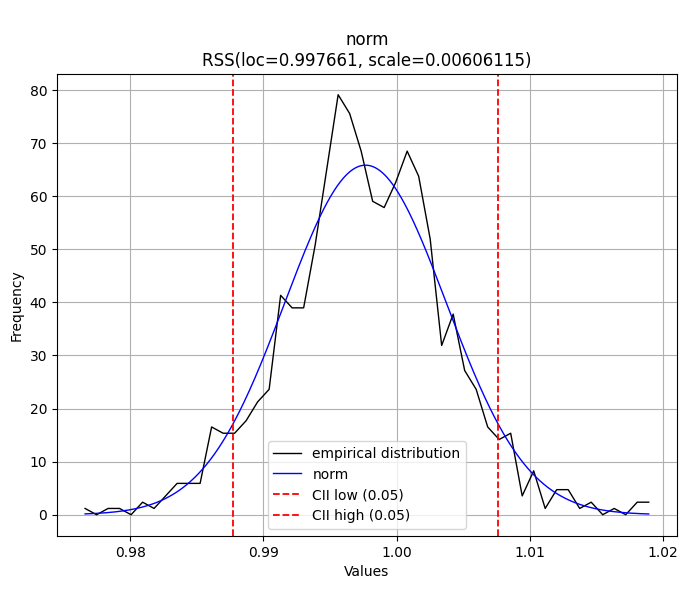

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm] [0.00 sec] [RSS: 0.0410208] [loc=3.724 scale=2.522]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..
3.7237338390428745 2.52220527243706


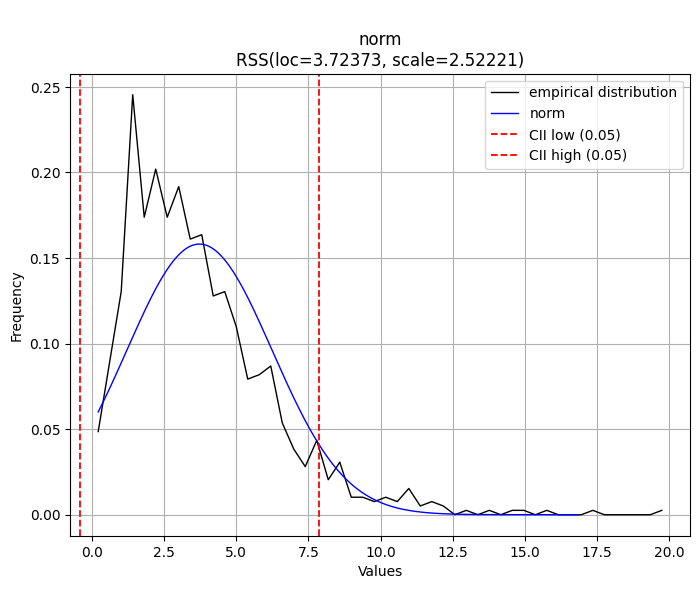

In [23]:
df_copy = df.loc[df.delta_angle<20]
for column in ['mdc_p', 'delta_angle']:
    dist = distfit(todf=True, distr='norm', bins=50)
    # dist = distfit(todf=True, bins=50)
    dist.fit_transform(df_copy[column])
    dist.plot(figsize=(8,6))

    # print(dist.summary['loc'].values[0], dist.summary['scale'].values[0])

    plt.show()

[distfit] >fit..
[distfit] >transform..
[distfit] >[norm] [0.00 sec] [RSS: 8059.74] [loc=1.047 scale=0.005]
[distfit] >Compute confidence interval [parametric]
[distfit] >plot..


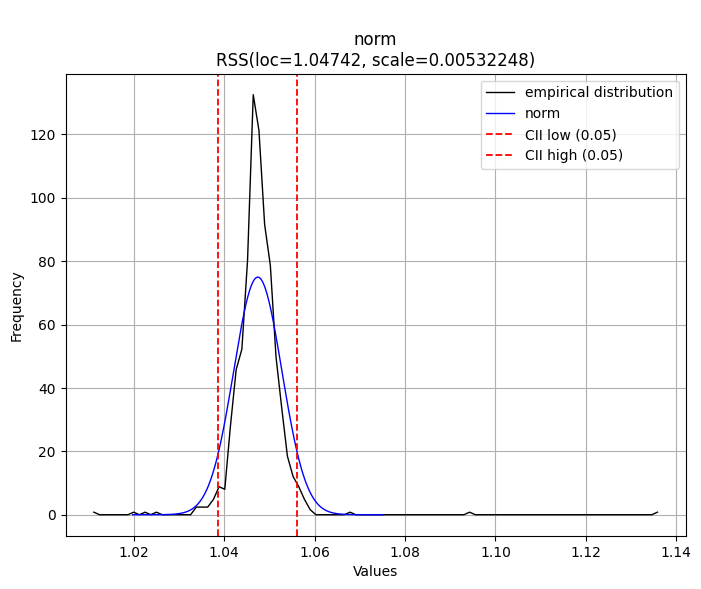

In [ ]:
def pxpypz2Theta(df):
    return math.acos(df['mdc_pz'] / np.linalg.norm(np.array([df['mdc_px'],df['mdc_py'],df['mdc_pz']])))

tmp_df = df.copy()
tmp_df['theta'] = df.apply(pxpypz2Theta, axis=1)


for column in ['theta']:
    dist = distfit(todf=True, distr='norm', bins=100)
    dist.fit_transform(tmp_df[column])
    dist.plot(figsize=(8,6))

    plt.show()